In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="4"
os.environ['EXP_DIR']='exps'

from collections import defaultdict
from itertools import combinations
from tqdm import tqdm
import os
from dataclasses import dataclass
from typing import List, Optional

import numpy as np
import torch
import yahp as hp
from composer import functional as cf
from composer.algorithms import BlurPoolHparams
from composer.datasets import DataLoaderHparams, DatasetHparams
from composer.trainer.devices import CPUDeviceHparams, DeviceHparams, GPUDeviceHparams
from composer.utils import dist, reproducibility

from sgdcollapse import utils
from sgdcollapse.data import data_registry
from sgdcollapse.exps.exp import Experiment
from sgdcollapse.exps.train import TrainExperiment
from sgdcollapse.exps.finetune import FinetuneExperiment

from sgdcollapse.models.loss import MSE

import scipy

from matplotlib import pyplot as plt
from multiprocessing import Pool

import seaborn as sns

plt.style.use("default")
rc = {"figure.figsize": (3.2, 2.4), "figure.dpi": 200, "figure.constrained_layout.use": True, "axes.grid": True,
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.5, "grid.linewidth": 0.5,
      "xtick.major.width": 0.5, "ytick.major.width": 0.5, "xtick.major.size": 2.5, "ytick.major.size": 2.5,
      "axes.labelsize": "small", "axes.titlesize": "small", "xtick.labelsize": "small", "ytick.labelsize": "small",
      "axes.titlepad": 2, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1, "patch.linewidth": 0}
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
sns.set_theme(style="ticks", context="paper", palette=sns.color_palette("tab10"), rc=rc)

In [3]:
def in_synapses(W, b=None, dtype=None):
    """
    Computes sum of in synapses to next layer
    """
    if np.ndim(W) == 4:
        in_sum = np.sum(W, axis=(1, 2, 3), dtype=dtype)
    else:
        in_sum = np.sum(W, axis=1, dtype=dtype)
    if b is not None:
        in_sum += b
    return in_sum


def out_synapses(W, b=None, dtype=None):
    """
    Computes sum of out synapses from last layer
    """
    if np.ndim(W) == 4:
        out_sum = np.sum(W, axis=(0, 2, 3), dtype=dtype)
    else:
        out_sum = np.sum(W, axis=0, dtype=dtype)
    return out_sum

def compute_eff_rnk(w_cat,epsilon=1e-8):
    s=np.linalg.svd(w_cat,compute_uv=False)
    s=s/s.sum()
    eff_rk=-(s*np.log(s+epsilon)).sum()
    return eff_rk

def compute_ind_node(none_zero_node,threshold2,return_dict=False):
    n_non_zero=len(none_zero_node)
    same_list=[]
    for i,j in combinations(np.arange(n_non_zero),2):
        if 2*(np.linalg.norm(none_zero_node[i]-none_zero_node[j],axis=-1)**2)/(np.linalg.norm(none_zero_node[i],axis=-1)**2+np.linalg.norm(none_zero_node[j],axis=-1)**2)<threshold2:
            same_list.append((i,j))
    dict_list=defaultdict(list)
    tempt_list=[]
    for i,j in same_list:
        if j in tempt_list:
            continue
        if i not in tempt_list:
            tempt_list.append(i)
        tempt_list.append(j)
        dict_list[i].append(j)
    for i in range(n_non_zero):
        if i in tempt_list:
            continue
        dict_list[i].append(i)
    n_none_ind=len(dict_list.keys())
    if return_dict:
        return n_none_ind,dict_list
    return n_none_ind

In [38]:
meta_results=[]
threshold=10e-2
threshold2=10e-2
def help_fun(replicate):
    for load_batch in tqdm([10000,20000,40000]):
        exp=TrainExperiment.create('../configs/cifar10_sgd/train_sce_gelu_lbn_final2.yaml',cli_args=False)
        exp.callbacks[1].save_interval='1000ba'
        exp.max_duration='200000ba'
        exp.train_batch_size=256
        exp.optimizer.lr=0.1
        exp.optimizer.weight_decay=0.0005

        state_dict=torch.load('../exps/'+exp.hash+'/replicate_%d/checkpoints/state_%dba.pt'%(replicate,load_batch),map_location=torch.device('cpu'))

        results=np.zeros([15,2])
        eff_rank=np.zeros(15)

        for layer_i in range(1,13):
            w1=state_dict['state']['model']['module.conv%d.weight'%layer_i].cpu().numpy()
            w2=state_dict['state']['model']['module.conv%d.bias'%layer_i].cpu().numpy()
            w3=state_dict['state']['model']['module.conv%d.weight'%(layer_i+1)].cpu().numpy()
            win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
            wout=np.swapaxes(w3,0,1).reshape(w3.shape[1],-1).T
            w_cat=np.concatenate([win,wout.T],-1)
            eff_rk=compute_eff_rnk(w_cat)

            zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
            none_zero_node=w_cat[~zero_node]
            n_none_ind=compute_ind_node(none_zero_node,threshold2)
            results[layer_i-1,0]=n_none_ind
            results[layer_i-1,1]=w1.shape[0]
            eff_rank[layer_i-1]=eff_rk

        layer_i=13
        w1=state_dict['state']['model']['module.conv%d.weight'%layer_i].cpu().numpy()
        w2=state_dict['state']['model']['module.conv%d.bias'%layer_i].cpu().numpy()
        w3=state_dict['state']['model']['module.fc14.weight'].cpu().numpy()
        win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
        wout=w3
        eff_rk=compute_eff_rnk(w_cat)
        zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
        none_zero_node=w_cat[~zero_node]
        n_none_ind=compute_ind_node(none_zero_node,threshold2)
        results[layer_i-1,0]=n_none_ind
        results[layer_i-1,1]=w1.shape[0]
        eff_rank[layer_i-1]=eff_rk

        for layer_i in [14,15]:
            w1=state_dict['state']['model']['module.fc%d.weight'%layer_i].cpu().numpy()
            w2=state_dict['state']['model']['module.fc%d.bias'%layer_i].cpu().numpy()
            w3=state_dict['state']['model']['module.fc%d.weight'%(layer_i+1)].cpu().numpy()
            win=np.concatenate([w1.reshape(w1.shape[0],-1),w2.reshape(w2.shape[0],-1)],axis=1)
            wout=w3
            w_cat=np.concatenate([win,wout.T],-1)
            eff_rk=compute_eff_rnk(w_cat)
            zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
            none_zero_node=w_cat[~zero_node]
            n_none_ind=compute_ind_node(none_zero_node,threshold2)
            results[layer_i-1,0]=n_none_ind
            results[layer_i-1,1]=w1.shape[0]
            eff_rank[layer_i-1]=eff_rk
        meta_results.append(np.concatenate([results,eff_rank[:,None]],-1))
    return meta_results
with Pool(8) as p:
    results=p.map(help_fun,range(8))
results=np.array(results)

100%|██████████| 3/3 [01:46<00:00, 35.37s/it]


In [34]:
train_loss_list=[]
test_acc_list=[]
for replicate in range(8):
    exp=TrainExperiment.create('../configs/cifar10_sgd/train_sce_gelu_lbn_final2.yaml',cli_args=False)
    exp.callbacks[1].save_interval='1000ba'
    exp.max_duration='200000ba'
    exp.train_batch_size=256
    exp.optimizer.lr=0.1
    exp.optimizer.weight_decay=0.0005
    log_dict=torch.load(f'../exps/'+exp.hash+'/replicate_%d/log.pt'%replicate,map_location=torch.device('cpu'))
    test_acc=[_[2].item() for _ in log_dict['metrics/eval/Accuracy']]
    train_loss=[_[2] for _ in log_dict['loss/train']]
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
train_batch=np.array([int(_[0].batch) for _ in log_dict['loss/train']])
test_batch=np.array([int(_[0].batch) for _ in log_dict['metrics/eval/Accuracy']])
train_loss_list=np.array(train_loss_list)
test_acc_list=np.array(test_acc_list)
test_acc_list=test_acc_list.reshape(8,-1,6).mean(axis=-1)*100
test_batch=test_batch.reshape(-1,6).mean(axis=-1)

test_acc_finetune_list_list=[]
for load_batch in tqdm([10000,20000,40000]):
    test_acc_finetune_list=[]
    for replicate in range(8):
        exp=FinetuneExperiment.create('../configs/cifar10_sgd/train_sce_gelu_lbn_final_finetune.yaml',cli_args=False)
        exp.train_batch_size=256
        exp.exp_hash='467611018aeb898bdf495b9824a89772'
        exp.load_batch=load_batch
        exp.optimizer.lr=0.01
        exp.optimizer.weight_decay=0.0005
        log_dict=torch.load(f'../exps/'+exp.hash+'/replicate_%d/log.pt'%replicate,map_location=torch.device('cpu'))
        test_acc=[_[2].item() for _ in log_dict['metrics/eval/Accuracy']]
        train_loss=[_[2] for _ in log_dict['loss/train']]
        test_acc_finetune_list.append(test_acc)
    test_batch_finetune=np.array([int(_[0].batch) for _ in log_dict['metrics/eval/Accuracy']])
    test_acc_finetune_list=np.array(test_acc_finetune_list)
    test_acc_finetune_list_list.append(test_acc_finetune_list)
test_acc_finetune_list_list=np.array(test_acc_finetune_list_list)
test_acc_finetune_list_list=test_acc_finetune_list_list.reshape(3,8,-1,6).mean(axis=-1)*100
test_batch_finetune=test_batch_finetune.reshape(-1,6).mean(axis=-1)

100%|██████████| 3/3 [00:13<00:00,  4.34s/it]


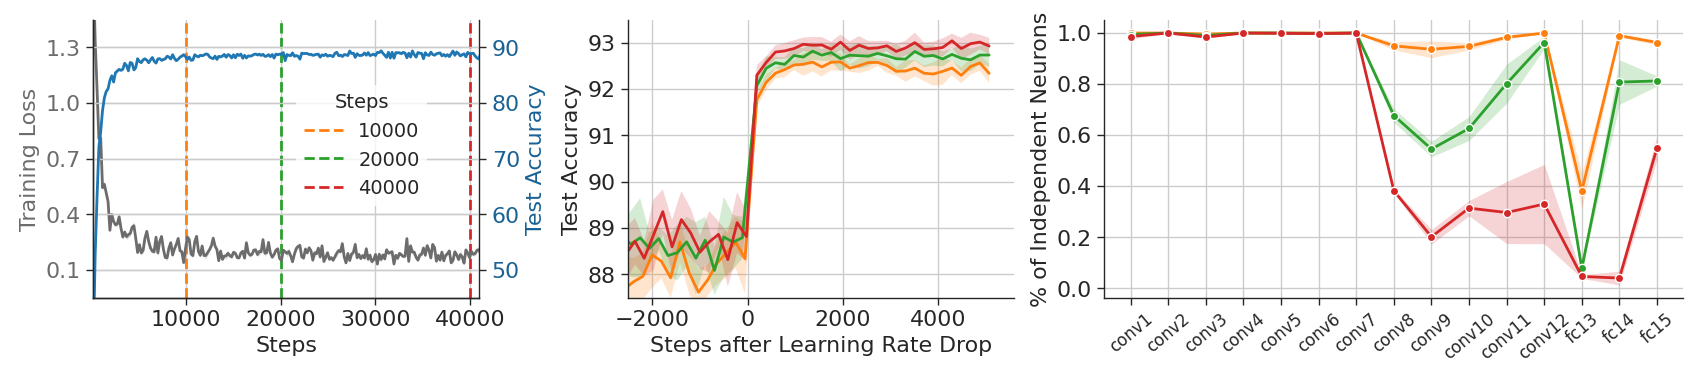

In [39]:
b_max=80000
fig, axes = plt.subplots(1,3,figsize=(2.8*3, 1.8), width_ratios=[1, 1,1.5])
for i,pt in enumerate([10000,20000,40000]):
    axes[0].axvline(pt,color=f"C{i+1}",label='%d'%pt,linestyle='dashed')
ax1color="#6c6c6c"
ax2color="#1a6294"
axes[0].spines[['right']].set_visible(True)
axes[0].plot(train_batch[195:b_max:195]+1,train_loss_list.mean(axis=0)[195:b_max:195], mec="w", mew="0.5",color=ax1color)
ax2 = axes[0].twinx()
ax2.plot(test_batch[:b_max//195]+1,test_acc_list.mean(axis=0)[:b_max//195])
ax2.fill_between(test_batch[:b_max//195]+1,test_acc_list.mean(axis=0)[:b_max//195]-test_acc_list.std(axis=0)[:b_max//195]/np.sqrt(len(test_acc_list)-1),test_acc_list.mean(axis=0)[:b_max//195]+test_acc_list.std(axis=0)[:b_max//195]/np.sqrt(len(test_acc_list)-1),alpha=0.2)
ax2.set_ylabel('Test Accuracy',color=ax2color)
ax2.set_yticks([40,50,60,70,80,90])
ax2.set_ylim(45,95)
ax2.tick_params(axis="y",labelcolor=ax2color)
axes[0].set_xlim(195, 41000)
axes[0].tick_params(axis="y", labelcolor=ax1color)
axes[0].fill_between(train_batch[195:b_max:195]+1,train_loss_list.mean(axis=0)[195:b_max:195]-train_loss_list.std(axis=0)[195:b_max:195]/np.sqrt(len(train_loss_list)-1),train_loss_list.mean(axis=0)[195:b_max:195]+train_loss_list.std(axis=0)[195:b_max:195]/np.sqrt(len(train_loss_list)-1),alpha=0.2,color=ax1color)
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Training Loss',color=ax1color)
axes[0].set_ylim([-0.05,1.45])
axes[0].set_yticks([0.1,0.4,0.7,1.0,1.3,])
lg=axes[0].legend(title="Steps", fontsize=7, title_fontsize=7,bbox_to_anchor=[0.5,0.8], loc="upper left")
lg.remove()
ax2.add_artist(lg)


b_max=26
for i,j in enumerate([10000,20000,40000]):
    x=np.concatenate([test_batch[:j//195]+1-j,test_batch_finetune[:b_max]])
    y=np.concatenate([test_acc_list.mean(axis=0)[:j//195],test_acc_finetune_list_list.mean(axis=1)[i][:b_max]])
    y_std=np.concatenate([test_acc_list.std(axis=0)[:j//195],test_acc_finetune_list_list.std(axis=1)[i][:b_max]])
    axes[1].plot(x,y, mec="w", mew="0.5",color=f"C{i+1}")
    axes[1].fill_between(x,y+y_std,y-y_std,alpha=0.2,color=f"C{i+1}")
    axes[1].set_xlim(-2500,5600)
axes[1].set_ylim(87.5,93.5)
axes[1].set_xlabel('Steps after Learning Rate Drop')
axes[1].set_ylabel('Test Accuracy')

for i,j in enumerate([10000,20000,40000]):
    y=results[:,i,:,0]/results[:,i,:,1]
    axes[2].plot(np.arange(15),y.mean(axis=0),color=f"C{i+1}",marker='o', ms=3, mec="white", mew=0.5)
    axes[2].fill_between(np.arange(15),y.mean(axis=0)-y.std(axis=0),y.mean(axis=0)+y.std(axis=0),alpha=0.2,color=f"C{i+1}")
axes[2].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
axes[2].tick_params(axis='x', which='major', labelsize=6)
axes[2].set_xticklabels(['conv%d'%i for i in range(1,13)]+['fc13','fc14','fc15'],rotation=40)
plt.savefig('Fig_4_CIFAR_10_2.pdf',bbox_inches='tight')

In [42]:
train_loss_list=[]
test_acc_list=[]
for replicate in range(8):
    exp=TrainExperiment.create('../configs/cifar100_sgd/train_sce_gelu_resnet.yaml',cli_args=False)
    exp.callbacks[1].save_interval='1000ba'
    exp.max_duration='200000ba'
    exp.train_batch_size=256
    exp.optimizer.lr=0.1
    exp.optimizer.weight_decay=0.0005
    log_dict=torch.load(f'../exps/'+exp.hash+'/replicate_%d/log.pt'%replicate,map_location=torch.device('cpu'))
    test_acc=[_[2].item() for _ in log_dict['metrics/eval/Accuracy']]
    train_loss=[_[2] for _ in log_dict['loss/train']]
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
train_batch=np.array([int(_[0].batch) for _ in log_dict['loss/train']])
test_batch=np.array([int(_[0].batch) for _ in log_dict['metrics/eval/Accuracy']])
train_loss_list=np.array(train_loss_list)
test_acc_list=np.array(test_acc_list)
test_acc_list=test_acc_list.reshape(8,-1,6).mean(axis=-1)*100
test_batch=test_batch.reshape(-1,6).mean(axis=-1)
test_acc_finetune_list_list=[]
for load_batch in tqdm([10000,20000,40000]):
    test_acc_finetune_list=[]
    for replicate in range(8):
        exp=FinetuneExperiment.create('../configs/cifar100_sgd/train_sce_gelu_resnet_finetune.yaml',cli_args=False)
        exp.train_batch_size=256
        exp.load_batch=load_batch
        exp.optimizer.lr=0.01
        exp.optimizer.weight_decay=0.0005
        log_dict=torch.load(f'../exps/'+exp.hash+'/replicate_%d/log.pt'%replicate,map_location=torch.device('cpu'))
        test_acc=[_[2].item() for _ in log_dict['metrics/eval/Accuracy']]
        train_loss=[_[2] for _ in log_dict['loss/train']]
        test_acc_finetune_list.append(test_acc)
    test_batch_finetune=np.array([int(_[0].batch) for _ in log_dict['metrics/eval/Accuracy']])
    test_acc_finetune_list=np.array(test_acc_finetune_list)
    test_acc_finetune_list_list.append(test_acc_finetune_list)
test_acc_finetune_list_list=np.array(test_acc_finetune_list_list)
test_acc_finetune_list_list=test_acc_finetune_list_list.reshape(3,8,-1,6).mean(axis=-1)*100
test_batch_finetune=test_batch_finetune.reshape(-1,6).mean(axis=-1)

100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


In [40]:
meta_results=[]
threshold=0.1
threshold2=0.1

bn_layer_names=[None,'module.bn1',
                'module.layer1.0.bn1','module.layer1.0.bn2',
                'module.layer1.1.bn1','module.layer1.1.bn2',
                'module.layer2.0.bn1','module.layer2.0.bn2',
                'module.layer2.1.bn1','module.layer2.1.bn2',
                 'module.layer3.0.bn1','module.layer3.0.bn2',
                'module.layer4.1.bn1','module.layer4.1.bn2']
weight_names=['module.conv1.weight',
              'module.layer1.0.conv1.weight','module.layer1.0.conv2.weight',
              'module.layer1.1.conv1.weight','module.layer1.1.conv2.weight',
              'module.layer2.0.conv1.weight','module.layer2.0.conv2.weight',
              'module.layer2.1.conv1.weight','module.layer2.1.conv2.weight',
              'module.layer3.0.conv1.weight','module.layer3.0.conv2.weight',
              'module.layer3.1.conv1.weight','module.layer3.1.conv2.weight',
              'module.layer4.0.conv1.weight','module.layer4.0.conv2.weight',
              'module.layer4.1.conv1.weight','module.layer4.1.conv2.weight','module.fc.weight']

def help_fun(replicate):
    for load_batch in tqdm([10000,20000,40000]):

        exp=TrainExperiment.create('../configs/cifar100_sgd/train_sce_gelu_resnet.yaml',cli_args=False)
        exp.callbacks[1].save_interval='1000ba'
        exp.max_duration='200000ba'
        exp.train_batch_size=256
        exp.optimizer.lr=0.1
        exp.optimizer.weight_decay=0.0005
        state_dict=torch.load('../exps/'+exp.hash+'/replicate_%d/checkpoints/state_%dba.pt'%(replicate,load_batch),map_location=torch.device('cpu'))

        results=np.zeros([17,2])
        eff_rank=np.zeros(17)
        
        for layer_i in range(len(weight_names)-1):
            w1=state_dict['state']['model'][weight_names[layer_i]].cpu().numpy()
            w2=state_dict['state']['model'][weight_names[layer_i+1]].cpu().numpy()
            win=w1.reshape(w1.shape[0],-1)
            wout=np.swapaxes(w2,0,1).reshape(w2.shape[1],-1).T
            w_cat=np.concatenate([win,wout.T],-1)
            
            eff_rk=compute_eff_rnk(w_cat)
            zero_node=np.linalg.norm(win,axis=-1)/np.linalg.norm(win,axis=-1).max()<threshold
            none_zero_node=w_cat[~zero_node]
            n_none_ind=compute_ind_node(none_zero_node,threshold2)
            results[layer_i-1,0]=n_none_ind
            results[layer_i-1,1]=w1.shape[0]
            eff_rank[layer_i-1]=eff_rk
        meta_results.append(np.concatenate([results,eff_rank[:,None]],-1))
    return meta_results
with Pool(8) as p:
    results=p.map(help_fun,range(8))
results=np.array(results)

100%|██████████| 3/3 [01:47<00:00, 35.82s/it]


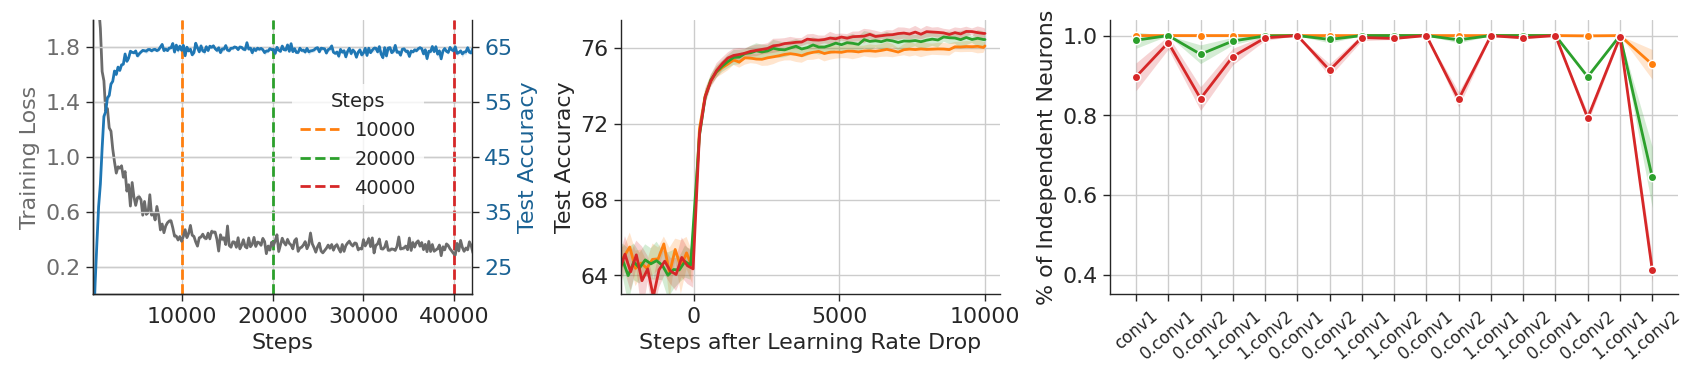

In [50]:
b_max=80000
fig, axes = plt.subplots(1,3,figsize=(2.8*3, 1.8), width_ratios=[1, 1,1.5])
for i,pt in enumerate([10000,20000,40000]):
    axes[0].axvline(pt,color=f"C{i+1}",label='%d'%pt,linestyle='dashed')
ax1color="#6c6c6c"
ax2color="#1a6294"
axes[0].spines[['right']].set_visible(True)
axes[0].plot(train_batch[195:b_max:195]+1,train_loss_list.mean(axis=0)[195:b_max:195], mec="w", mew="0.5",color=ax1color)
ax2 = axes[0].twinx()
ax2.plot(test_batch[:b_max//195]+1,test_acc_list.mean(axis=0)[:b_max//195])
ax2.fill_between(test_batch[:b_max//195]+1,test_acc_list.mean(axis=0)[:b_max//195]-test_acc_list.std(axis=0)[:b_max//195]/np.sqrt(len(test_acc_list)-1),test_acc_list.mean(axis=0)[:b_max//195]+test_acc_list.std(axis=0)[:b_max//195]/np.sqrt(len(test_acc_list)-1),alpha=0.2)
ax2.set_ylabel('Test Accuracy',color=ax2color)
ax2.set_yticks([25,35,45,55,65])
ax2.set_ylim(20,70)
ax2.tick_params(axis="y",labelcolor=ax2color)
axes[0].set_xlim(195, 42000)
axes[0].tick_params(axis="y", labelcolor=ax1color)
axes[0].fill_between(train_batch[195:b_max:195]+1,train_loss_list.mean(axis=0)[195:b_max:195]-train_loss_list.std(axis=0)[195:b_max:195]/np.sqrt(len(train_loss_list)-1),train_loss_list.mean(axis=0)[195:b_max:195]+train_loss_list.std(axis=0)[195:b_max:195]/np.sqrt(len(train_loss_list)-1),alpha=0.2,color=ax1color)
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Training Loss',color=ax1color)
axes[0].set_ylim([0.0,2.0])
axes[0].set_yticks([0.2,0.6,1.0,1.4,1.8,])
lg=axes[0].legend(title="Steps", fontsize=7, title_fontsize=7,bbox_to_anchor=[0.5,0.8], loc="upper left")
lg.remove()
ax2.add_artist(lg)

b_max=55
for i,j in enumerate([10000,20000,40000]):
    x=np.concatenate([test_batch[:j//195]+1-j,test_batch_finetune[:b_max]])
    y=np.concatenate([test_acc_list.mean(axis=0)[:j//195],test_acc_finetune_list_list.mean(axis=1)[i][:b_max]])
    y_std=np.concatenate([test_acc_list.std(axis=0)[:j//195],test_acc_finetune_list_list.std(axis=1)[i][:b_max]])
    axes[1].plot(x,y, mec="w", mew="0.5",color=f"C{i+1}")
    axes[1].fill_between(x,y+y_std,y-y_std,alpha=0.2,color=f"C{i+1}")
    axes[1].set_xlim(-2500,10500)
axes[1].set_ylim(63,77.5)
axes[1].set_yticks([64,68,72,76])
axes[1].set_xlabel('Steps after Learning Rate Drop')
axes[1].set_ylabel('Test Accuracy')

for i,j in enumerate([10000,20000,40000]):
    y=results[:,i,:,0]/results[:,i,:,1]
    axes[2].plot(np.arange(17),y.mean(axis=0),color=f"C{i+1}",marker='o', ms=3, mec="white", mew=0.5)
    axes[2].fill_between(np.arange(17),y.mean(axis=0)-y.std(axis=0),y.mean(axis=0)+y.std(axis=0),alpha=0.2,color=f"C{i+1}")
axes[2].set_ylabel(r'% of Independent Neurons')
axes[2].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
axes[2].tick_params(axis='x', which='major', labelsize=6)
axes[2].set_xticklabels(['conv1','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2','0.conv1','0.conv2','1.conv1','1.conv2'],rotation=40)
plt.savefig('Fig_4_CIFAR_100_2.pdf',bbox_inches='tight')